In [1]:
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [2]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from efficientnet.keras import EfficientNetB3
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Set the data path and categories
data_path = '/kaggle/input/koa-1500/MedicalExpert-I'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 156
data = []
label = []

# Load the images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

In [4]:
data = np.array(data) / 255.0
data_rgb = np.repeat(data[..., np.newaxis], 3, -1)
label = np.array(label)
new_label = np_utils.to_categorical(label)

# Perform SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
data_reshaped = data_rgb.reshape(data_rgb.shape[0], -1)
data_smote, new_label_smote = smote.fit_resample(data_reshaped, new_label)
data_smote = data_smote.reshape(data_smote.shape[0], img_size, img_size, 3)

# Count the number of samples per class
unique_classes, class_counts = np.unique(np.argmax(new_label_smote, axis=1), return_counts=True)

# Print the class distribution
print("Class Distribution After SMOTE:")
for i, class_name in enumerate(categories):
    print(f"{class_name}: {class_counts[i]} samples")
    
# Split the data into train, test, and validation sets
x_train, x_test, y_train, y_test = train_test_split(data_smote, new_label_smote, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

datagen_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(x_train, y_train, batch_size=16)
val_generator = datagen_val.flow(x_val, y_val, batch_size=16)

Class Distribution After SMOTE:
1Doubtful: 514 samples
3Moderate: 514 samples
4Severe: 514 samples
2Mild: 514 samples
0Normal: 514 samples


In [5]:
# Define the model architecture
model = Sequential()

# EfficientNet B3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
model.summary()

44107200/44107200 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 5, 5, 1536)       10783528  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 10,791,213
Trainable params: 10,703,917
Non-trainable params: 87,296
________________________________________

In [19]:
# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(train_generator,
                    epochs=90,
                    validation_data=val_generator,
                    callbacks=[checkpoint])

Epoch 1/90
113/113 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.9116
Epoch 1: val_accuracy improved from -inf to 0.89105, saving model to /kaggle/working/model2.h5
113/113 [==============================] - 20s 175ms/step - loss: 0.2439 - accuracy: 0.9116 - val_loss: 0.3672 - val_accuracy: 0.8911
Epoch 2/90
113/113 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9294
Epoch 2: val_accuracy improved from 0.89105 to 0.89494, saving model to /kaggle/working/model2.h5
113/113 [==============================] - 19s 166ms/step - loss: 0.1989 - accuracy: 0.9294 - val_loss: 0.3497 - val_accuracy: 0.8949
Epoch 3/90
113/113 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9238
Epoch 3: val_accuracy improved from 0.89494 to 0.89883, saving model to /kaggle/working/model2.h5
113/113 [==============================] - 19s 166ms/step - loss: 0.2227 - accuracy: 0.9238 - val_loss: 0.3515 - val_accuracy: 0.8988
Epoch 4/90
113/113 

In [20]:
# Load the best weights
model.load_weights('/kaggle/working/model2.h5')

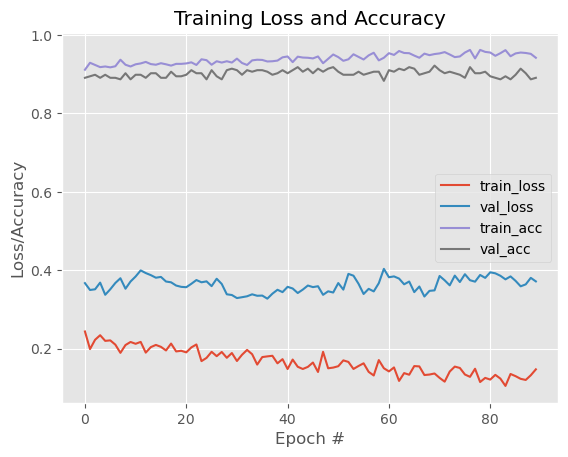

In [21]:
# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("EfficientNet_Model")



In [24]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

Test loss: 0.45323777198791504
Test accuracy: 0.8677042722702026


17/17 [==============================] - 1s 63ms/step
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       105
           1       0.99      0.87      0.93       100
           2       0.91      0.97      0.94       105
           3       0.84      0.80      0.82        95
           4       0.85      0.94      0.89       109

    accuracy                           0.87       514
   macro avg       0.87      0.87      0.87       514
weighted avg       0.87      0.87      0.87       514



<Figure size 640x480 with 0 Axes>

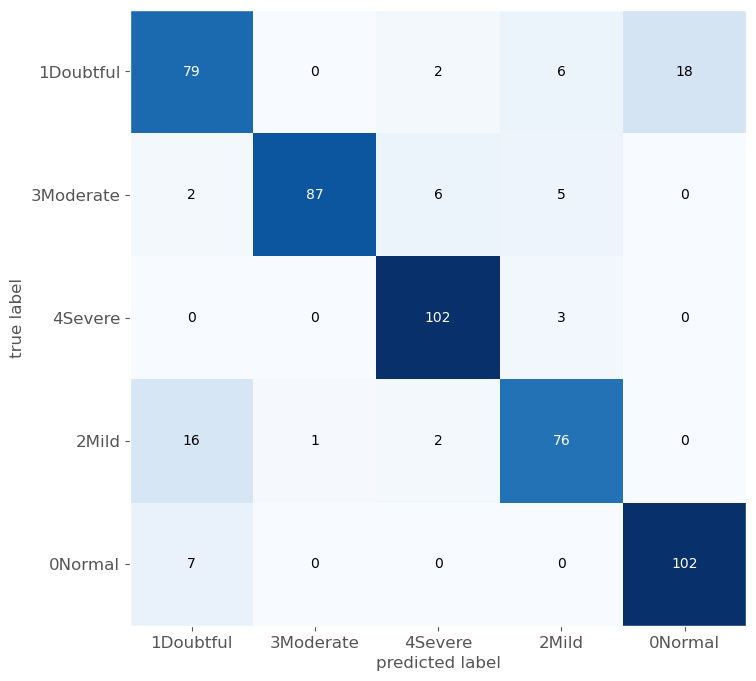

1/1 [==============================] - 0s 33ms/step
A.I predicts: 2Mild
Correct prediction for label 0 is 1Doubtful


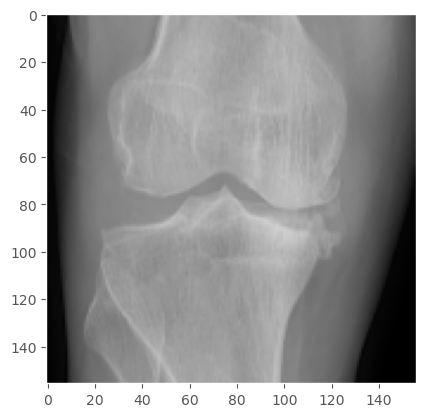

In [23]:
# Get the predictions for the test set
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the classification report
report = classification_report(np.argmax(y_test, axis=1), predicted_labels)
print(report)

# Plot the confusion matrix
test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=12)
plt.yticks(range(len(categories)), categories, fontsize=12)
plt.show()

# Select a single image from the test set for prediction
X = 32
img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = np.expand_dims(img_single, 0)

# Make prediction on the single image
predictions_single = model.predict(img_single)
print('A.I predicts:', categories[np.argmax(predictions_single)])
print("Correct prediction for label", np.argmax(y_test[X]), 'is', categories[np.argmax(y_test[X])])

# Display the single image
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()
